# 0) Libraries

In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: starlette
    Found existing installation: starlette 0.26.1
    Uninstalling starlette-0.26.1:
      Successfully uninstalled starlette-0.26.1
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.95.1
    Uninstalling fastapi-0.95.1:
      Successfully uninstalled fastapi-0.95.1


In [3]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
import torchmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from lightning.pytorch.callbacks import ModelCheckpoint


# 1) Preparing Data

Download data from [Tiny ImageNet.](https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet)

First of all we will create csv files for train and val data. Csv files will contain path to image and its label.

In train folder there are 200 subfolders, each of them contains 500 images. We will create csv file with 100000 rows. Each row will contain path to image and its label.

Labels in this case are names of subfolders. We will create dictionary with keys as names of subfolders and values as numbers from 0 to 199. 

In [3]:
!mkdir data

In [4]:
data_path = '../input/tiny-imagenet/tiny-imagenet-200'
labels = set(os.listdir(os.path.join(data_path, 'train')))
labels.discard('.DS_Store')
label_dict = {label: i for i, label in enumerate(labels)}
# Train set
train_dict = {}
for dirname, dirs, files in os.walk(os.path.join(data_path, 'train')):
    for file in files:
        if file.endswith('.JPEG'):
            path = os.path.join(dirname, file)
            label = file.split('_')[0]
            label = label_dict[label]
            train_dict[path] = label

# Validation set
val_dict = {}
with open(os.path.join(data_path,'val/val_annotations.txt'), 'r') as f:
    for line in f.readlines():
        line = line.split('\t')
        path = os.path.join(os.path.join(data_path,'val'),'images', line[0])
        label = line[1]
        val_dict[path] = label_dict[label]

# Convert dicts to csv using pandas
train_df = pd.DataFrame.from_dict(train_dict, orient='index')
train_df.reset_index(inplace=True)
train_df.columns = ['path', 'label']
train_df.to_csv('data/train.csv', index=False)

val_df = pd.DataFrame.from_dict(val_dict, orient='index')
val_df.reset_index(inplace=True)
val_df.columns = ['path', 'label']
val_df.to_csv('data/val.csv', index=False)

In [5]:
set(val_df.label.unique()) == set(train_df.label.unique())

True

# 2) Creating dataset, data loaders, and lightning data module

In [17]:
class MyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img = Image.open(path).convert('RGB') # type: ignore

        if self.transform:
            img = self.transform(img)

        return img, label

In [19]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0, 1] -> [-1, 1]
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0, 1] -> [-1, 1]
        ]
    ),
}

In [20]:
train_dataset = MyDataset('data/train.csv', transform=data_transforms['train'])

In [9]:
count = 0
for idx, (img, label) in enumerate(train_dataset):
    if img.shape != (3, 224, 224):
        count += 1
    
    if idx == 1000:
        break

In [21]:
class MyDataModule(L.LightningDataModule):
    def __init__(self, data_path="./", batch_size=64, num_workers=0, train_transforms=None, val_transforms=None):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms

    def prepare_data(self):
        # already prepared
        return

    def setup(self, stage=None):
        # Note transforms.ToTensor() scales input images
        # to 0-1 range
        self.train = MyDataset(
            os.path.join(self.data_path, "train.csv"),
            transform=self.train_transforms,
        )

        self.valid = MyDataset(
            os.path.join(self.data_path, "val.csv"),
            transform=self.val_transforms,
        )

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return valid_loader

In [22]:
dm = MyDataModule('./data', batch_size=64, num_workers=0, train_transforms=data_transforms['train'], val_transforms=data_transforms['val'])
dm.setup()

In [23]:
for images, labels in dm.train_dataloader():  
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [24]:
labels

tensor([ 97,  61,  60,  33, 132,  36,  37,  63,  11, 169,  38,  45, 196, 189,
        134,  54, 155,  35, 160, 165, 153, 125,  99,  84,   5, 129,  10,  56,
         18,  38, 152, 171,  11, 168, 150,  26,  50,  40,  68, 171,  87,  94,
        158, 130, 179,  63, 112,  54, 133,  42, 145,  75, 195, 142,  64, 108,
         47,  64, 153,  64,  33,  41, 154, 103])

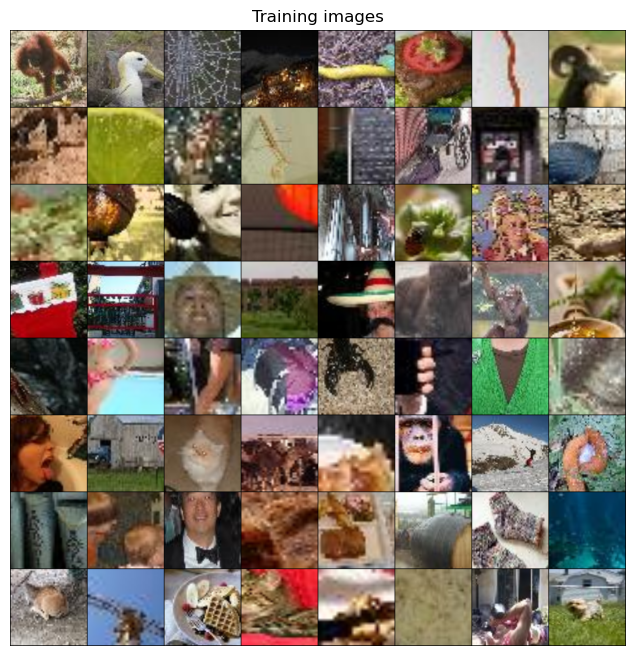

In [14]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

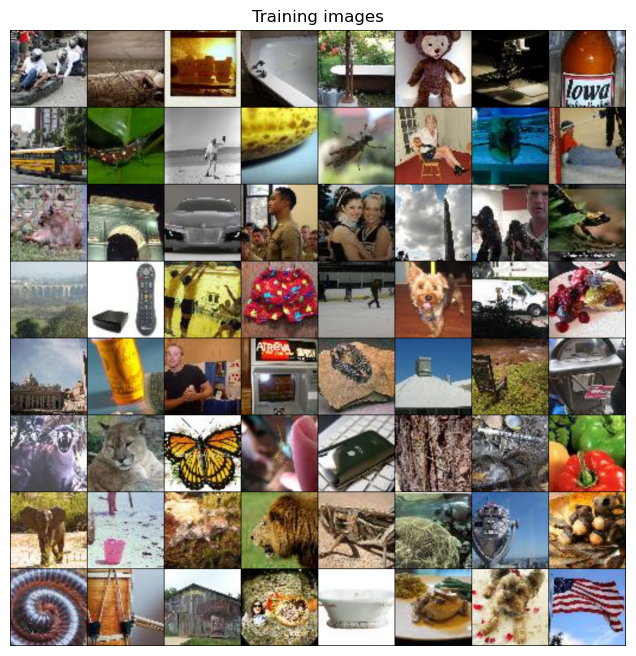

In [25]:
for images, labels in dm.val_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

# 3) Create a LightningModule

In [26]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=200)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=200)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=200)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# 4) Initialize a model and create training loop

In [27]:
L.seed_everything(123)
torch.manual_seed(123)

weights = ResNet50_Weights.DEFAULT
preprocess_transform = weights.transforms()


resnet50_model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layersf
for param in resnet50_model.parameters():
    param.requires_grad = False

in_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(in_features, 200)

lightning_model = LightningModel(resnet50_model, learning_rate=0.001)
dm = MyDataModule('./data', 
                  batch_size=64, 
                  num_workers=4, 
                  train_transforms=preprocess_transform, 
                  val_transforms=preprocess_transform
)

callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

trainer = L.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices='auto',
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
    callbacks = callbacks,
)

Global seed set to 123
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
trainer.fit(lightning_model, dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.9 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
409 K     Trainable params
23.5 M    Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


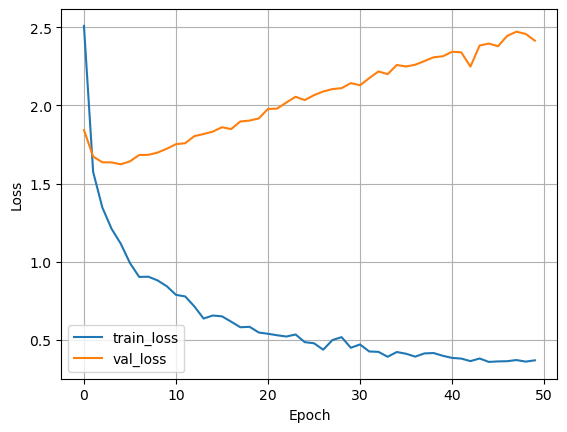

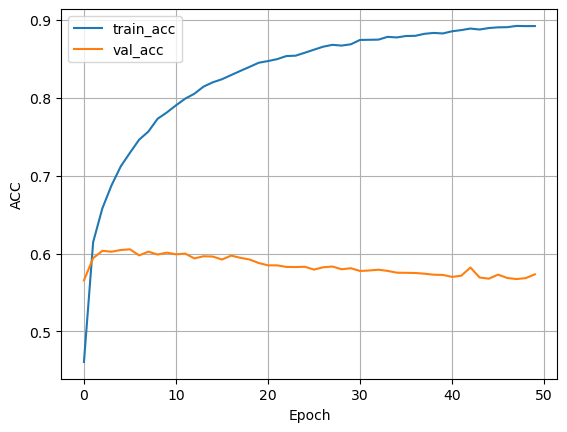

In [20]:
log_dir = trainer.logger.log_dir

metrics = pd.read_csv(f"{log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i # type: ignore
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig('loss.png')

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig('acc.png')
